In [1]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
git is already the newest version (1:2.17.1-1ubuntu0.13).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
libbz2-dev set to manually installed.
tar is already the newest version (1.29b-2ubuntu0.3).
unzip is already the newest version (6.0-21ubuntu1.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2.2).
zlib1g-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  autoconf automake autopoint autotools-dev debhelper dh-autoreconf
  dh-strip-nondeterminism file freepats gettext gettext-base gir1.2

In [2]:
!pip install vizdoom[gym]
!pip install stable-baselines3
!pip install sb3-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 27.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.3 MB 36 kB/s 
     |████████████████████████████████| 624 kB 79.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.13-cp38-cp38-linux_x86_64.whl size=14100978 sha256=b83b1a967172e697e95175d353abaf37dac38264d10dbf31f8dda263876a2cc7
  Stored in directory: /root/.cache/pip/wheels/37/99/55/98e23ef4fc09fb59d49068f9248120f352a4bcc210fe0de1ed
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697661 sha256=399b00e8203e1757bff03b7b83d554fa892b2d4f3a88daed2f7e7dafb6637932
  Stored in directory: /root/.cache/pip/wheels/e7/2f/ab/

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import gym
import vizdoom.gym_wrapper

from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
import pickle
import time
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor

In [17]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, shape=(60, 80)):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]

        # Create new observation space with the new shape
        num_channels = env.observation_space["rgb"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(0, 255, shape=new_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = cv2.resize(observation["rgb"], self.image_shape_reverse)
        return observation

In [22]:
DEFAULT_ENV = "VizdoomDefendCenter-v0"
N_STEPS = 128
FRAME_SKIP = 2
build_name = "PPO_Frame_Skip_2"


checkpoint_callback = CheckpointCallback(save_freq=1e4,
                                        save_path=f'./{build_name}_checkpoints/')
env = gym.make(DEFAULT_ENV, frame_skip=FRAME_SKIP)
env = ObservationWrapper(env)
env = Monitor(env)

agent = PPO("CnnPolicy", env, n_steps=N_STEPS, verbose=1)
# agent = RecurrentPPO("CnnLstmPolicy", env, verbose=1)

start = time.time()
agent.learn(total_timesteps=250000, callback=checkpoint_callback)
end = time.time()

print(f"Time taken: {end - start}")

agent.save(build_name)
with open(f'{build_name}_rewards.pickle', 'wb') as handle:
    pickle.dump(env.get_episode_rewards(), handle,
                protocol=pickle.HIGHEST_PROTOCOL)


Streaming output truncated to the last 5000 lines.
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 374         |
|    ep_rew_mean          | 11.8        |
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 1717        |
|    time_elapsed         | 2490        |
|    total_timesteps      | 219776      |
| train/                  |             |
|    approx_kl            | 0.021704163 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.137      |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00793    |
|    n_updates            | 17160       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 0.0512      |
-----------------------------------------
-------------------------

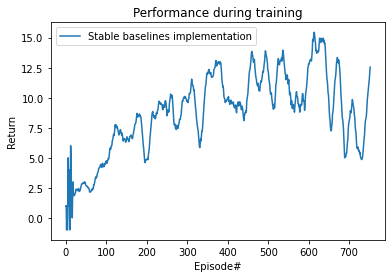

In [23]:

stable_baselines_episode_rewards = env.get_episode_rewards()
stable_baselines_moving_average_of_rewards = stable_baselines_episode_rewards.copy()
for i in range(20, len(stable_baselines_episode_rewards)):
  stable_baselines_moving_average_of_rewards[i] = np.mean(stable_baselines_episode_rewards[i - 20: i])

plt.xlabel("Episode#") 
plt.ylabel("Return") 
plt.title("Performance during training")
plt.plot(stable_baselines_moving_average_of_rewards, label='Stable baselines implementation')  
plt.legend()
plt.show()

In [1]:
!zip -r PPO_Frame_Skip_2_checkpoints.zip PPO_Frame_Skip_2_checkpoints 

	zip warning: name not matched: PPO_Frame_Skip_2_checkpoints

zip error: Nothing to do! (try: zip -r PPO_Frame_Skip_2_checkpoints.zip . -i PPO_Frame_Skip_2_checkpoints)


In [ ]:
all_checkpoints = os.listdir(f"./{build_name}_checkpoints")

env = gym.make(DEFAULT_ENV, frame_skip=FRAME_SKIP)
env = ObservationWrapper(env)
env = Monitor(env)

best_performance = 0
best_performer = ""
checkpoint_performances = []
for checkpoint in all_checkpoints:
  if "rl_model" not in checkpoint:
    continue
  model = PPO.load(f"./{build_name}_checkpoints/{checkpoint}")
  episodic_rewards = []
  for i in range(10):
    done = False
    obs = env.reset()
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    episodic_rewards.append(total_reward)

  checkpoint_performance = np.mean(episodic_rewards)
  checkpoint_performances.append(checkpoint_performance)
  if checkpoint_performance > best_performance:
    best_performance = checkpoint_performance
    best_performer = checkpoint

print(f"checkpoint {best_performer} did best with score {best_performance}")
print(checkpoint_performances)
      

